This can only be run if the .h5 is present. It is too large to upload. Alternatively run the model script again, then you have it (but it could be slightly different due to new iteration)

32/32 [==============================] - 15s 72ms/step
Classification Accuracy: 0.9590
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       500
           1       0.96      0.96      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



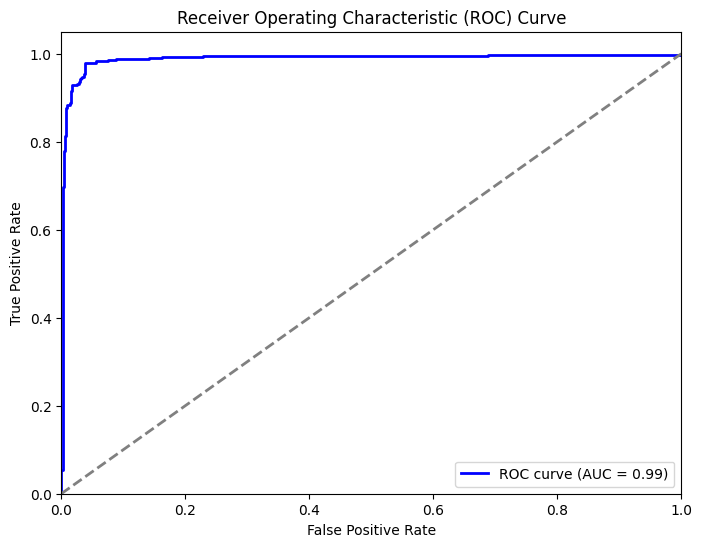

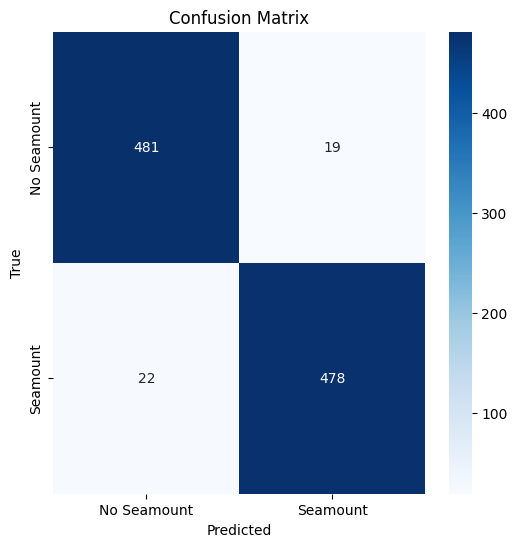

Displaying 20 misclassified images out of 41 total misclassified images...


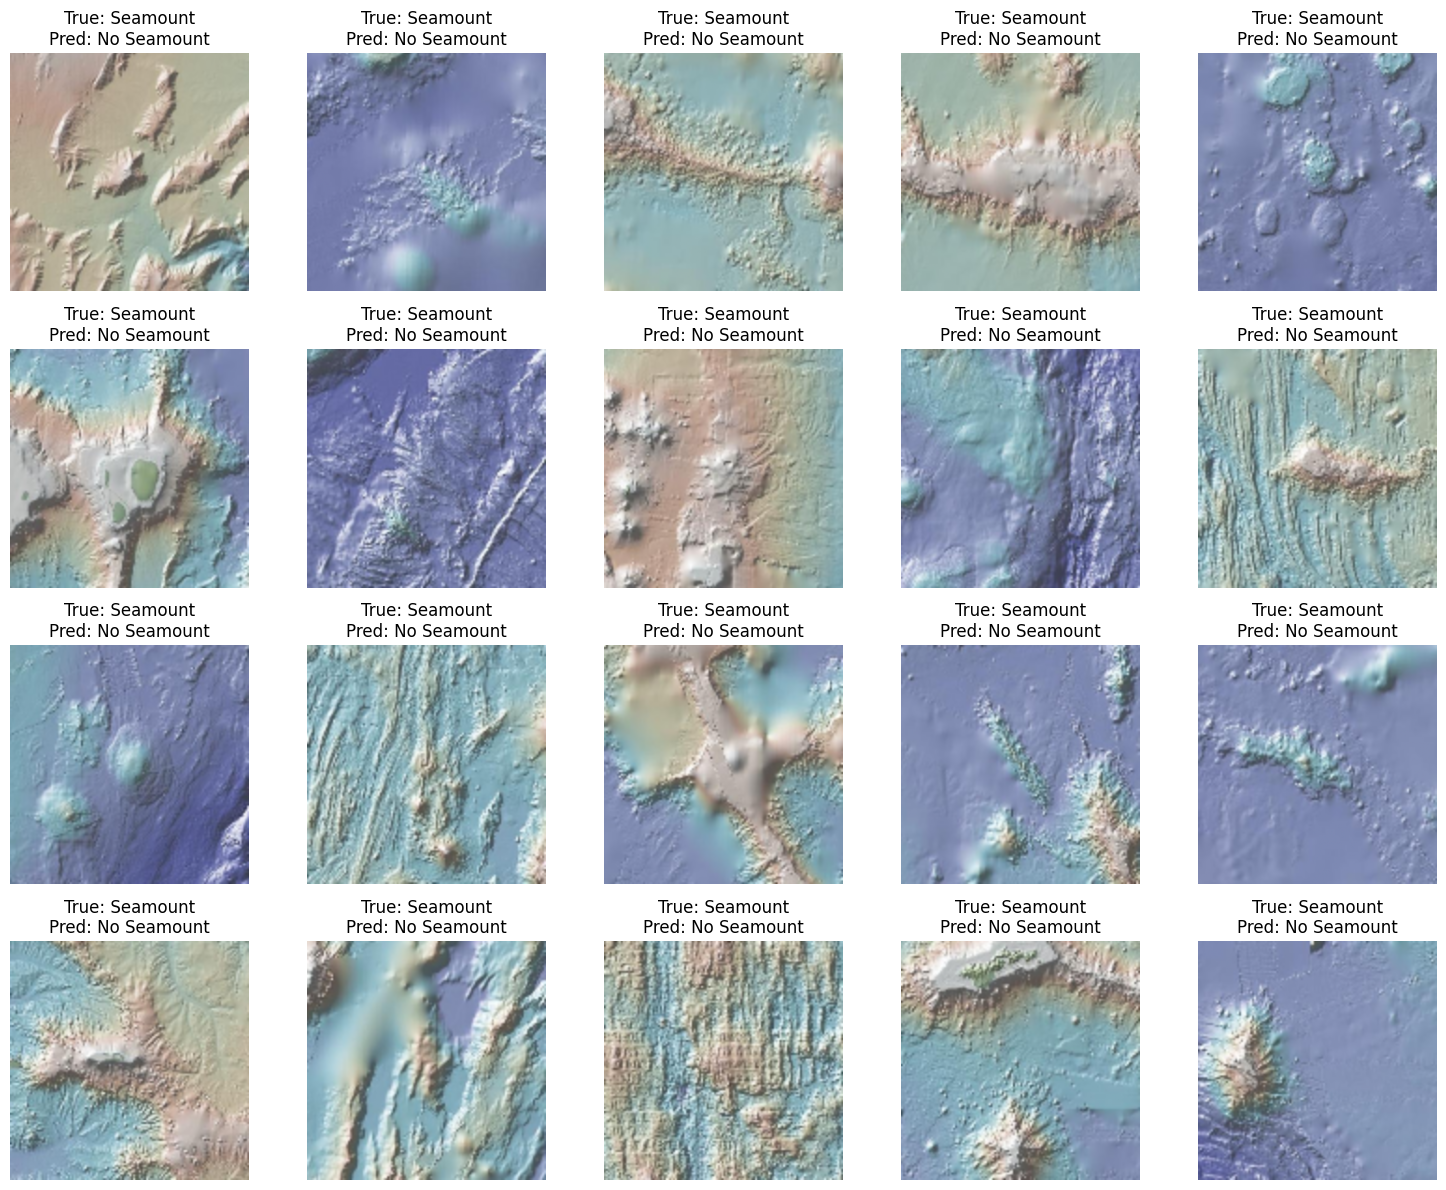

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Constants
IMAGE_SIZE = (256, 256)  # Resize images to 256x256
MODEL_PATH = "objdet_1_1.h5"  # Path to the saved model

# Folder paths
image_dir_with_seamount = "./temp_processed_data_241208/with_seamount_manual1"
image_dir_without_seamount = "./temp_processed_data_241208/without_seamounts_manual1"

# Huber loss definition (required for model loading)
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    large_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, large_error_loss)

# Load the trained model
model = tf.keras.models.load_model(MODEL_PATH, custom_objects={'huber_loss': huber_loss})

# Function to load and preprocess images
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load in color (BGR format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load all images and labels
def load_dataset():
    images = []
    labels = []

    # Load images from "with_seamount_manual2"
    for img_name in os.listdir(image_dir_with_seamount):
        img_path = os.path.join(image_dir_with_seamount, img_name)
        if os.path.isfile(img_path):
            img = load_image(img_path)
            resized_img = cv2.resize(img, IMAGE_SIZE)
            images.append(resized_img)
            labels.append(1)  # Class label for "with_seamount"

    # Load images from "without_seamounts_manual1"
    for img_name in os.listdir(image_dir_without_seamount):
        img_path = os.path.join(image_dir_without_seamount, img_name)
        if os.path.isfile(img_path):
            img = load_image(img_path)
            resized_img = cv2.resize(img, IMAGE_SIZE)
            images.append(resized_img)
            labels.append(0)  # Class label for "without_seamount"

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Load dataset
images, labels = load_dataset()

# Make predictions (only for the classification output)
pred_classes = model.predict(images)[0]  # Get only the class predictions

# Convert class predictions from probabilities to binary (0 or 1)
pred_class_labels = (pred_classes > 0.5).astype(int)

# Compute accuracy
accuracy = accuracy_score(labels, pred_class_labels)
print(f"Classification Accuracy: {accuracy:.4f}")

# Detailed classification report
print(classification_report(labels, pred_class_labels))

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, pred_classes)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (chance level)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Compute confusion matrix
conf_matrix = confusion_matrix(labels, pred_class_labels)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Seamount', 'Seamount'], yticklabels=['No Seamount', 'Seamount'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

import math

# Function to display misclassified images
def display_misclassified_images(images, true_labels, pred_labels, num_examples=5):
    # Identify misclassified images
    misclassified_indices = [i for i in range(len(true_labels)) if true_labels[i] != pred_labels[i]]
    
    # Get the number of misclassified images
    num_misclassified = len(misclassified_indices)
    
    # Limit the number of examples to display
    num_examples = min(num_examples, num_misclassified)
    
    # Display the misclassified images
    print(f"Displaying {num_examples} misclassified images out of {num_misclassified} total misclassified images...")

    # Get the misclassified images and their labels
    misclassified_images = [images[i] for i in misclassified_indices[:num_examples]]
    misclassified_labels = [true_labels[i] for i in misclassified_indices[:num_examples]]
    misclassified_preds = [pred_labels[i] for i in misclassified_indices[:num_examples]]
    
    # Calculate rows and columns for the grid layout
    rows = math.ceil(num_examples / 5)  # Show 5 images per row (adjustable)
    cols = min(5, num_examples)  # Max 5 columns, or fewer if less than 5 images
    
    # Plot the images
    plt.figure(figsize=(cols * 3, rows * 3))  # Adjust figure size based on number of images
    
    for i in range(num_examples):
        ax = plt.subplot(rows, cols, i + 1)  # Create a grid of subplots
        plt.imshow(misclassified_images[i])
        true_label = "Seamount" if misclassified_labels[i] == 1 else "No Seamount"
        pred_label = "Seamount" if misclassified_preds[i] == 1 else "No Seamount"
        ax.set_title(f"True: {true_label}\nPred: {pred_label}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Call the function to display misclassified images
display_misclassified_images(images, labels, pred_class_labels, num_examples=20)